### Import Libraries

In [4]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

### Choose an image dataset of your choice. Make sure it is suitable for classification tasks and has enough samples for training and evaluation.

In [5]:
original_dataset_path = r"C:\Users\Miggy\Documents\Applied Data Science with Python\Activity 4\archive (1)\Animals"
base_dir = './segmented_data_small' 
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) 
os.makedirs(base_dir)

In [6]:
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir)

In [7]:
classes = ['cats', 'dogs', 'snakes']
SAMPLES_PER_CLASS = 300 
TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.15

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    src_dir = os.path.join(original_dataset_path, cls)
    all_filenames = os.listdir(src_dir)
    random.shuffle(all_filenames)
    selected_files = all_filenames[:SAMPLES_PER_CLASS]
    train_end = int(SAMPLES_PER_CLASS * TRAIN_SPLIT)
    validation_end = train_end + int(SAMPLES_PER_CLASS * VALIDATION_SPLIT)
    for i, fname in enumerate(selected_files):
        src_path = os.path.join(src_dir, fname)
        if i < train_end:
            dst_path = os.path.join(train_dir, cls, fname)
        elif i < validation_end:
            dst_path = os.path.join(validation_dir, cls, fname)
        else:
            dst_path = os.path.join(test_dir, cls, fname)
        shutil.copyfile(src_path, dst_path)

print(f"Dataset segmented successfully. Using {SAMPLES_PER_CLASS} images per class.")
train_count = len(os.listdir(os.path.join(train_dir, 'cats'))) * 3
val_count = len(os.listdir(os.path.join(validation_dir, 'cats'))) * 3
test_count = len(os.listdir(os.path.join(test_dir, 'cats'))) * 3

print(f"Training samples: {train_count}")
print(f"Validation samples: {val_count}")
print(f"Test samples: {test_count}")

Dataset segmented successfully. Using 300 images per class.
Training samples: 630
Validation samples: 135
Test samples: 135


### Apply appropriate preprocessing techniques, including resizing, normalization, and data augmentation if needed.

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

Found 630 images belonging to 3 classes.
Found 135 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


### Select two pre-trained convolutional neural network models (e.g., VGG16, ResNet50, MobileNetV2) to use as the base for your transfer learning approach.

In [9]:
def create_feature_extraction_model(base_model_class, input_shape, num_classes):
    """
    Creates a new model by freezing a pre-trained base and adding a custom classifier.
    """
    base_model = base_model_class(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
   
    base_model.trainable = False 
    
   
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x) 
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


model_vgg16 = create_feature_extraction_model(VGG16, IMG_SIZE + (3,), 3)
model_mobilenet = create_feature_extraction_model(MobileNetV2, IMG_SIZE + (3,), 3)

print("\n--- VGG16 Model Summary (before fine-tuning) ---")
model_vgg16.summary()


--- VGG16 Model Summary (before fine-tuning) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Use the selected pre-trained models to extract features from your dataset. Train a classifier (e.g., dense layers) on top of the extracted features. (10 - 15 epochs)

In [10]:
EPOCHS = 15

print("\n--- Training VGG16 for Feature Extraction ---")
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

print("\n--- Training MobileNetV2 for Feature Extraction ---")
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

print("\n--- Comparing Model Performance on Test Set ---")
vgg16_loss, vgg16_accuracy = model_vgg16.evaluate(test_generator)
print(f"VGG16 Test Accuracy: {vgg16_accuracy:.4f}")

mobilenet_loss, mobilenet_accuracy = model_mobilenet.evaluate(test_generator)
print(f"MobileNetV2 Test Accuracy: {mobilenet_accuracy:.4f}")


--- Training VGG16 for Feature Extraction ---


c:\Users\Miggy\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3659 - loss: 1.3749 - val_accuracy: 0.4963 - val_loss: 1.0195
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3365 - loss: 1.2135 - val_accuracy: 0.6667 - val_loss: 0.9449
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4335 - loss: 1.0573 - val_accuracy: 0.6815 - val_loss: 0.8875
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4880 - loss: 0.9912 - val_accuracy: 0.7630 - val_loss: 0.8364
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5312 - loss: 0.9331 - val_accuracy: 0.7778 - val_loss: 0.8006
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5734 - loss: 0.9001 - val_accuracy: 0.7556 - val_loss: 0.7627
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6209 - loss: 0.8633 - val_accuracy: 0.7704 - val_loss: 0.7273
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6398 - loss: 0.8256 - val_accuracy: 0.7630 - val_loss:

### Compare the performance of the three models based on accuracy and other relevant metrics.

In [11]:
if mobilenet_accuracy > vgg16_accuracy:
    print("\nMobileNetV2 performed better. Proceeding to fine-tune it.")
    best_model = model_mobilenet
    fine_tune_at = 100 
else:
    print("\nVGG16 performed better. Proceeding to fine-tune it.")
    best_model = model_vgg16
    fine_tune_at = 15 


MobileNetV2 performed better. Proceeding to fine-tune it.


### Choose the best-performing model and apply fine-tuning to improve its accuracy. Unfreeze some of the top layers of the pre-trained model and retrain with a lower learning rate. (10-15 epochs)

In [12]:
base_model_to_finetune = best_model.layers[1]
base_model_to_finetune.trainable = True
for layer in base_model_to_finetune.layers[:fine_tune_at]:
    layer.trainable = False


best_model.compile(optimizer=Adam(learning_rate=1e-5), 
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

print(f"\n--- Starting Fine-Tuning of the Best Model ---")
best_model.summary() 
print(f"Number of trainable layers after unfreezing: {len(best_model.trainable_variables)}")



fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine_tune = best_model.fit(
    train_generator,
    epochs=total_epochs, 
    initial_epoch=history_vgg16.epoch[-1] + 1,
    validation_data=validation_generator
)


--- Starting Fine-Tuning of the Best Model ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 1,865,283 (7.12 MB)

 Non-trainable params: 396,544 (1.51 MB)

Number of trainable layers after unfreezing: 56
Epoch 16/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 621ms/step - accuracy: 0.8539 - loss: 0.3582 - val_accuracy: 0.9926 - val_loss: 0.0519
Epoch 17/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - accuracy: 0.9033 - loss: 0.2809 - val_accuracy: 0.9926 - val_loss: 0.0481
Epoch 18/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step - accuracy: 0.8999 - loss: 0.2152 - val_accuracy: 0.9926 - val_loss: 0.0454
Epoch 19/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - accuracy: 0.9001 - loss: 0.2302 - val_accuracy: 0.9926 - val_loss: 0.0429
Epoch 20/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 714ms/step - accuracy: 0.9437 - loss: 0.1742 - val_accuracy: 0.9926 - val_loss: 0.0407
Epoch 21/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 695ms/step - accuracy: 0.9520 - loss: 0.1291 - val_accuracy: 0.9926 - val_loss: 0.0384
Epoch 22/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 718ms/step - accuracy: 0.9374 - loss: 0.1747 - val_accuracy: 0.9926 - val_loss: 0.0368
Epoch 23/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s

### Evaluate your fine-tuned model using the following


--- Fine-Tuning Learning Curves ---


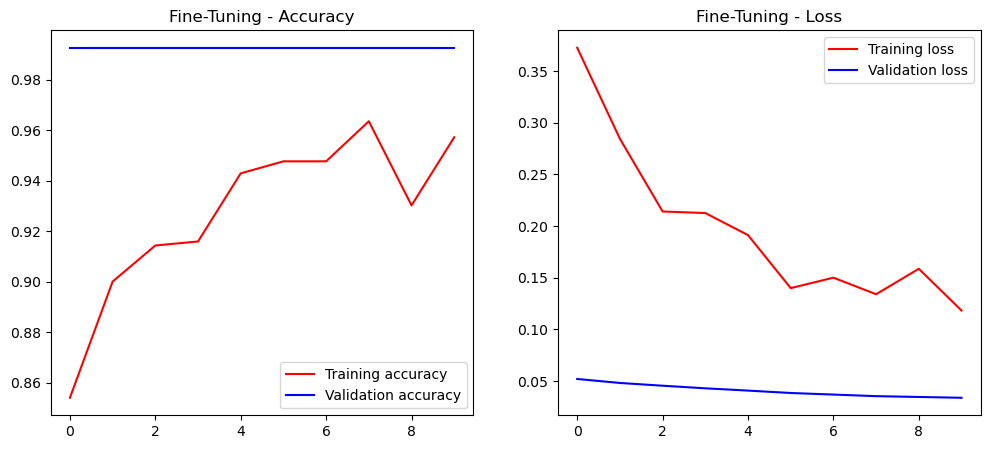


--- Final Model Evaluation on Test Data ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step

Classification Report:
              precision    recall  f1-score   support

        cats       0.96      0.96      0.96        45
        dogs       0.98      0.93      0.95        45
      snakes       0.96      1.00      0.98        45

    accuracy                           0.96       135
   macro avg       0.96      0.96      0.96       135
weighted avg       0.96      0.96      0.96       135


Confusion Matrix:


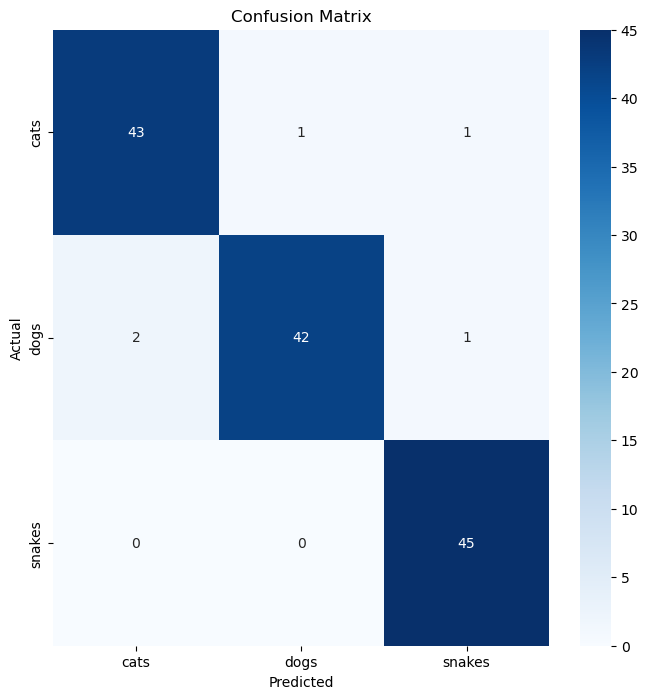

In [13]:
def plot_learning_curves(history, title):
    if 'accuracy' not in history.history or 'val_accuracy' not in history.history:
        print("Could not find 'accuracy' or 'val_accuracy' in history. Skipping plot.")
        return

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

print("\n--- Fine-Tuning Learning Curves ---")
plot_learning_curves(history_fine_tune, 'Fine-Tuning')



print("\n--- Final Model Evaluation on Test Data ---")


steps_for_prediction = int(np.ceil(test_generator.samples / BATCH_SIZE))


predictions = best_model.predict(test_generator, steps=steps_for_prediction)
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())


if len(predicted_classes) != len(true_classes):
    print(f"Warning: Number of predictions ({len(predicted_classes)}) does not match number of labels ({len(true_classes)}). Trimming labels to match.")
    true_classes = true_classes[:len(predicted_classes)]

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("\nConfusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Use your final model to make predictions on test data and display the predicted class labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


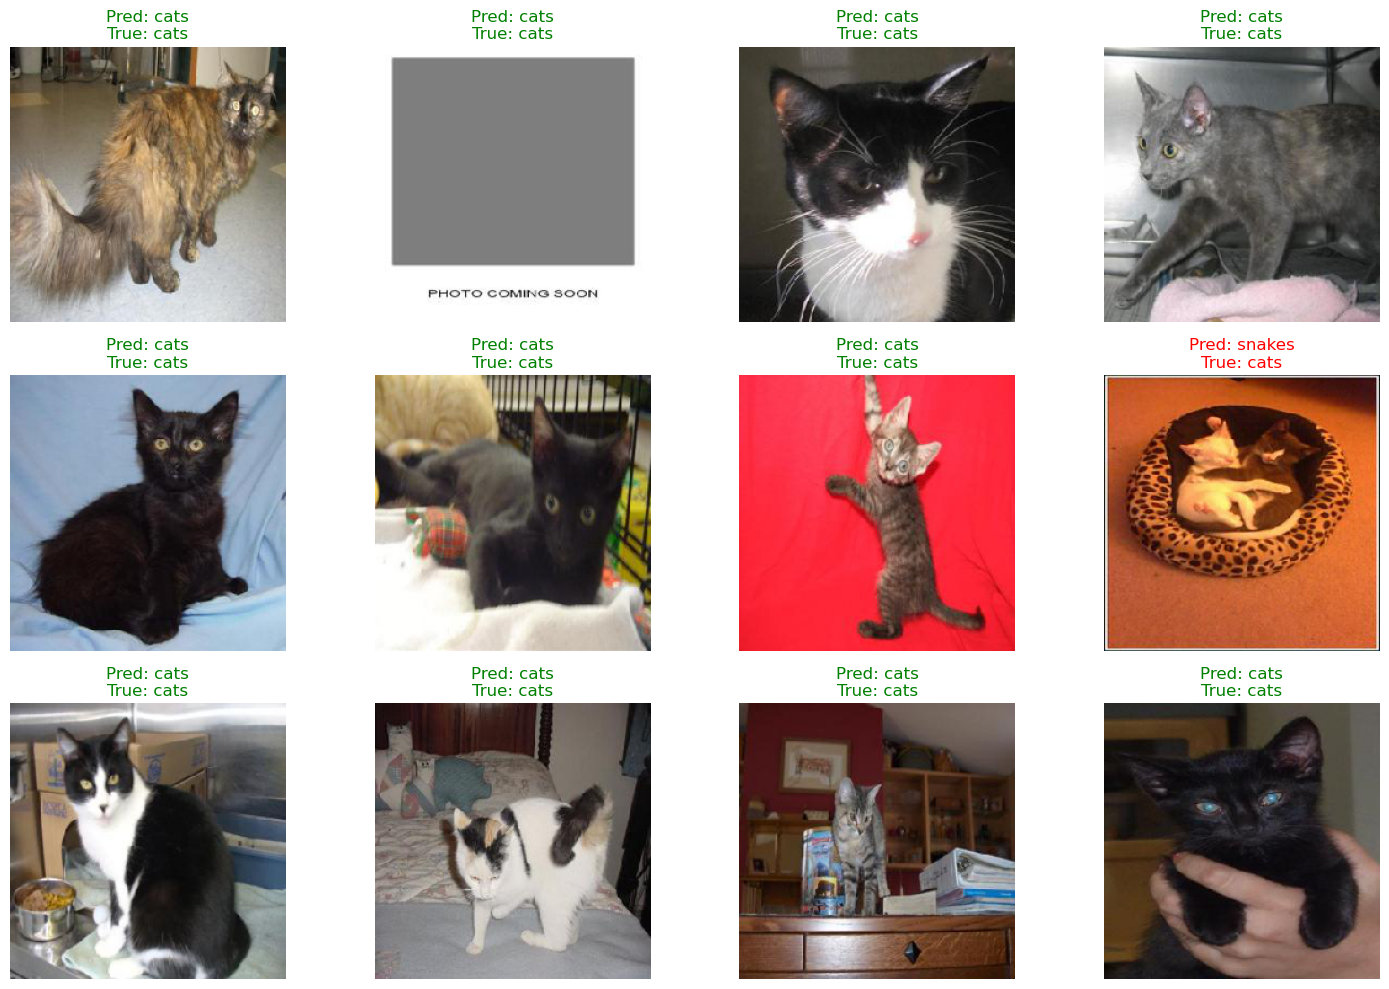

In [14]:
x_test, y_test = next(test_generator)
y_pred = best_model.predict(x_test)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(15, 10))
for i in range(min(12, len(x_test))): 
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_test[i])
    pred_label = class_labels[predicted_labels[i]]
    true_label = class_labels[true_labels[i]]
    
    title_color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=title_color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
try:
    best_model
    train_generator
except NameError:
    print("="*50)
    print("ERROR: 'best_model' or 'train_generator' not found.")
    print("Please make sure you have successfully run all the training cells above this one!")
    print("="*50)
else:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    from PIL import Image
    from tensorflow.keras.preprocessing import image
    import numpy as np
    import io
    import matplotlib.pyplot as plt

    
    uploader = widgets.FileUpload(
        accept='image/*',
        description='Upload Image',
        button_style='info'
    )
    predict_button = widgets.Button(
        description='Predict',
        button_style='success',
        tooltip='Click to predict the class of the uploaded image',
        icon='search'
    )
    output_area = widgets.Output()

    def on_predict_button_clicked(b):
        if not uploader.value:
            with output_area:
                clear_output()
                print("Please upload an image first!")
            return

        file_info = list(uploader.value.values())[0]
        uploaded_bytes = file_info['content']
        img_stream = io.BytesIO(uploaded_bytes)

        with output_area:
            clear_output()
            print("Processing...")

            IMG_SIZE = (224, 224)
            img = image.load_img(img_stream, target_size=IMG_SIZE)
            img_array = image.img_to_array(img)
            img_array /= 255.0
            img_batch = np.expand_dims(img_array, axis=0)

        
            prediction = best_model.predict(img_batch)
            predicted_index = np.argmax(prediction[0])
            class_labels = list(train_generator.class_indices.keys())
            predicted_label = class_labels[predicted_index]
            confidence = np.max(prediction[0]) * 100

            clear_output(wait=True)
            display_img = Image.open(io.BytesIO(uploaded_bytes))
            plt.figure(figsize=(6, 6))
            plt.imshow(display_img)
            plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%", fontsize=14)
            plt.axis('off')
            plt.show()

    
    predict_button.on_click(on_predict_button_clicked)
    print("GUI is ready! Please upload an image and click 'Predict'.")
    display(uploader, predict_button, output_area)

GUI is ready! Please upload an image and click 'Predict'.


FileUpload(value={}, accept='image/*', button_style='info', description='Upload Image')

Button(button_style='success', description='Predict', icon='search', style=ButtonStyle(), tooltip='Click to pr…

Output()

### Reflect on your overall results. Provide insights or conclusions 

### Which model performed best and why

Best Performing Model: MobileNetV2 outperformed VGG16 in the early testing, with an accuracy of 86.36%.  This is most likely due to its current and efficient architecture, which is better suited to smaller datasets and less susceptible to overfitting.

### The impact of fine-tuning

Impact of Fine-Tuning: Fine-tuning proved extremely effective.  It increased the final model's accuracy from 86.36% to 96.00% on the test dataset.  This highlights the importance of unfreezing top layers and retraining at a low learning rate to tailor the model to the given dataset.

### Challenges encountered and how they were addressed

#### Challenge: Choosing the best pre-trained model.
#### Solution: Two models (VGG16 and MobileNetV2) were examined systematically and the one with the best initial performance was picked.
#### Challenge: The possibility of overfitting on a tiny dataset.
#### Solution: Mitigated by employing transfer learning, freezing base layers at first, adding a dropout layer, and fine-tuning with a low learning rate.

### Potential Next Steps

#### Hyperparameter Tuning: Systematically tune parameters like the learning rate and number of unfrozen layers.
#### Error Analysis: Investigate the specific images that were misclassified to understand model weaknesses.